In [22]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline



In [23]:
cuda = False
torch.manual_seed(42)
device = torch.device( "cpu")


In [24]:
features = np.load("sider_latent.npy")
X_train, X_test = train_test_split(features, test_size=0.2, random_state = 42)

In [25]:
class NoisyDataset(Dataset):
    def __init__(self,d,cc=100, downscale=0.25):
        self.data = d.copy()
        for i in range(1,cc): 
            self.data = np.concatenate((self.data, d.copy()),axis=0)
        self.noisy = self.data + np.asarray(np.random.randn(self.data.shape[0],self.data.shape[1]) * downscale , dtype=np.float32) 
    def __getitem__(self,i):
        return  [self.noisy[i], self.data[i]]
    def __len__(self):
        return len(self.data)

In [26]:
class DnAE(nn.Module):
    def __init__(self, enc, dec ):
        super(DnAE, self).__init__()
        enc_layers = list(zip(enc[:-1], enc[1:]))
        dec_layers = list(zip(dec[:-1], dec[1:]))

        def create(layers):    
            m = []
            for l in layers:
                m.append(nn.Linear(*l))
                m.append(nn.ReLU())
            return nn.Sequential(*m[:-1])    

        self.encoder = create(enc_layers)
        self.decoder = create(dec_layers)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

def loss_function(recon_x, x):
    return F.mse_loss(recon_x, x)

In [28]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.to(device)
        optimizer.zero_grad()
        recon_x = model(X)
        loss = loss_function(recon_x, y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format( epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [39]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()
    test_loss /= len(test_loader.dataset)
    print('====> Validation loss: {:.4f}'.format(test_loss))
    return test_loss

In [33]:
train_loader = DataLoader(NoisyDataset(X_train,cc=400,downscale=0.1), batch_size=32, shuffle=True)
test_loader = DataLoader(NoisyDataset(X_test,cc=400,downscale=0.1), batch_size=32, shuffle=True)

In [31]:
n_dim = features[0].shape[0]
enc = [n_dim,25]
dec = [25,n_dim]

In [40]:
model = DnAE(enc,dec).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)
log_interval=1000
train_loss, test_loss = [], []
E = range(10)
for epoch in E:
    train_loss.append(train(epoch))
    test_loss.append(test(epoch))

DnAE(
  (encoder): Sequential(
    (0): Linear(in_features=56, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=56, bias=True)
  )
)
====> Epoch: 0 Average loss: 0.0602
====> Validation loss: 0.0123
====> Epoch: 1 Average loss: 0.0098
====> Validation loss: 0.0116
====> Epoch: 2 Average loss: 0.0094
====> Validation loss: 0.0117
====> Epoch: 3 Average loss: 0.0094
====> Validation loss: 0.0117
====> Epoch: 4 Average loss: 0.0093
====> Validation loss: 0.0117
====> Epoch: 5 Average loss: 0.0093
====> Validation loss: 0.0116
====> Epoch: 6 Average loss: 0.0093
====> Validation loss: 0.0116
====> Epoch: 7 Average loss: 0.0093
====> Validation loss: 0.0116
====> Epoch: 8 Average loss: 0.0093
====> Validation loss: 0.0116
====> Epoch: 9 Average loss: 0.0093
====> Validation loss: 0.0115


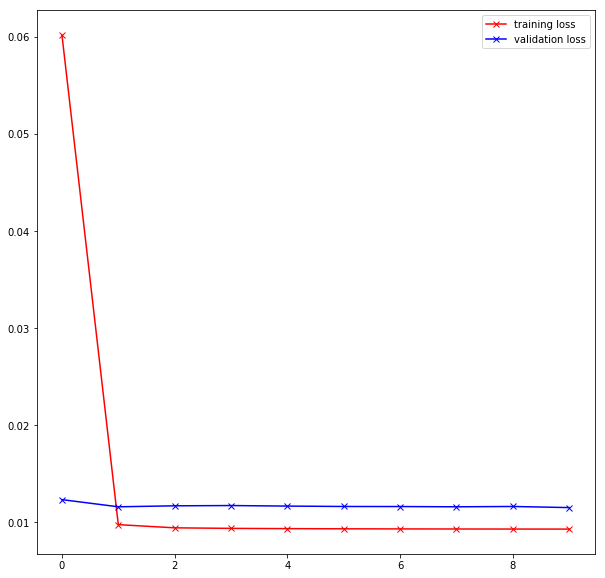

In [41]:
fig = plt.figure(figsize=(10,10))
plt.plot(E, train_loss,'bx-', c="r", label="training loss")
plt.plot(E, test_loss,'bx-', c="b", label="validation loss")
plt.legend()


### 3d Bottleneck

In [42]:
n_dim = features[0].shape[0]
enc = [n_dim,10,3]
dec = [3, 10,n_dim]

In [43]:
model = DnAE(enc,dec).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print(model)
log_interval=1000
train_loss, test_loss = [], []
E = range(40)
for epoch in E:
    train_loss.append(train(epoch))
    test_loss.append(test(epoch))

DnAE(
  (encoder): Sequential(
    (0): Linear(in_features=56, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=56, bias=True)
  )
)
====> Epoch: 0 Average loss: 0.1824
====> Validation loss: 0.1523
====> Epoch: 1 Average loss: 0.1569
====> Validation loss: 0.1486
====> Epoch: 2 Average loss: 0.1525
====> Validation loss: 0.1461
====> Epoch: 3 Average loss: 0.1500
====> Validation loss: 0.1448
====> Epoch: 4 Average loss: 0.1482
====> Validation loss: 0.1439
====> Epoch: 5 Average loss: 0.1466
====> Validation loss: 0.1432
====> Epoch: 6 Average loss: 0.1449
====> Validation loss: 0.1429
====> Epoch: 7 Average loss: 0.1438
====> Validation loss: 0.1426
====> Epoch: 8 Average loss: 0.1431
====> Validation loss: 0.1426
====> Epoch: 9 Average loss: 0.1426
====> Validation loss: 0.1425
====

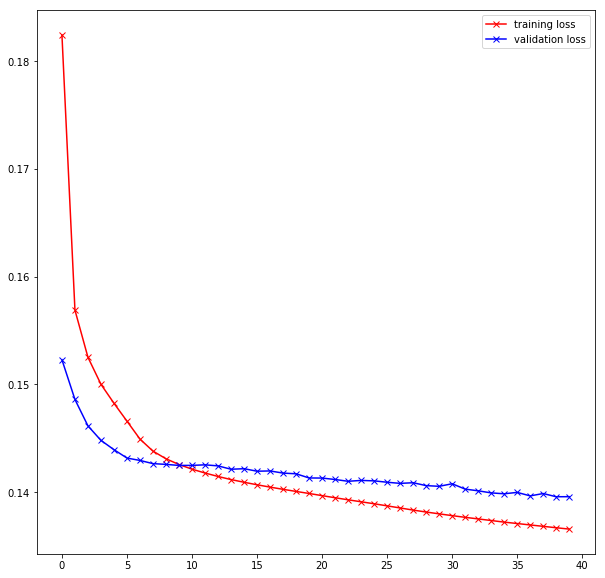

In [44]:
fig = plt.figure(figsize=(10,10))
plt.plot(E, train_loss,'bx-', c="r", label="training loss")
plt.plot(E, test_loss,'bx-', c="b", label="validation loss")
plt.legend()


### Visualisation of synthetic molecule representation

In [45]:
import numpy as np

In [46]:
model=model.eval()

In [47]:
ltnt = model.encoder(torch.Tensor(features)).detach().numpy()

In [48]:
synthetic = np.load("synthetic.latent.npy")

In [49]:
synth = model.encoder(torch.Tensor(synthetic)).detach().numpy()

Text(0,0.5,'Dim2')

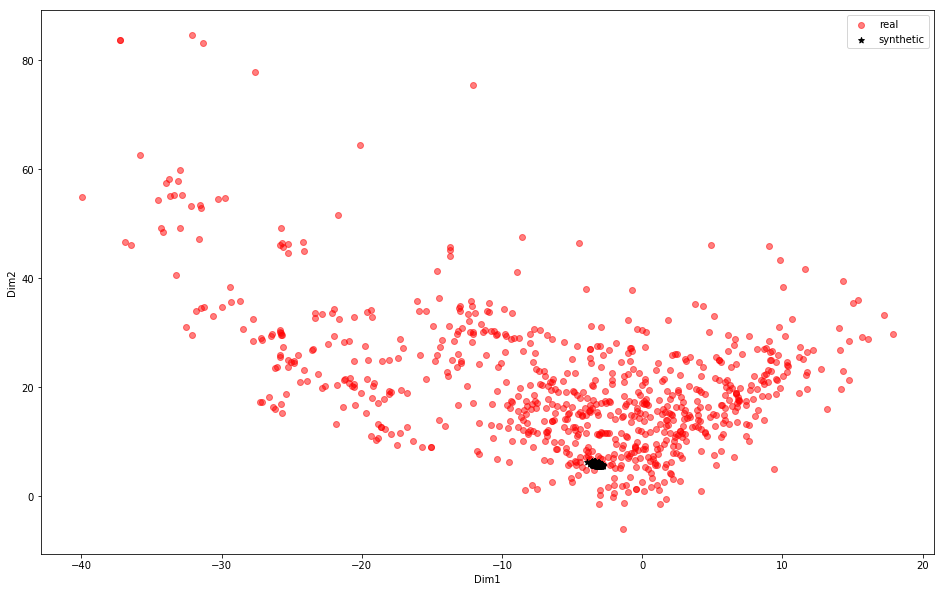

In [50]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

plt.scatter(ltnt[:,0], ltnt[:,1], c="r", marker="o", alpha = 0.5, label="real")
plt.scatter(synth[:,0], synth[:,1], c="k", marker="*", label="synthetic")

plt.legend()
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')


Text(0,0.5,'Dim3')

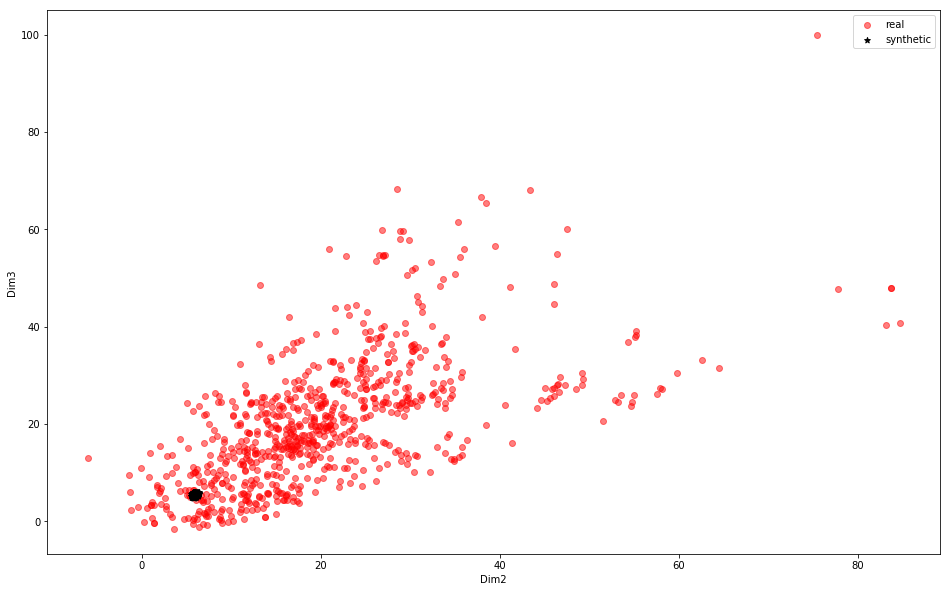

In [51]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

plt.scatter(ltnt[:,1], ltnt[:,2], c="r", marker="o", alpha = 0.5, label="real")
plt.scatter(synth[:,1], synth[:,2], c="k", marker="*", label="synthetic")

plt.legend()
ax.set_xlabel('Dim2')
ax.set_ylabel('Dim3')


Text(0,0.5,'Dim3')

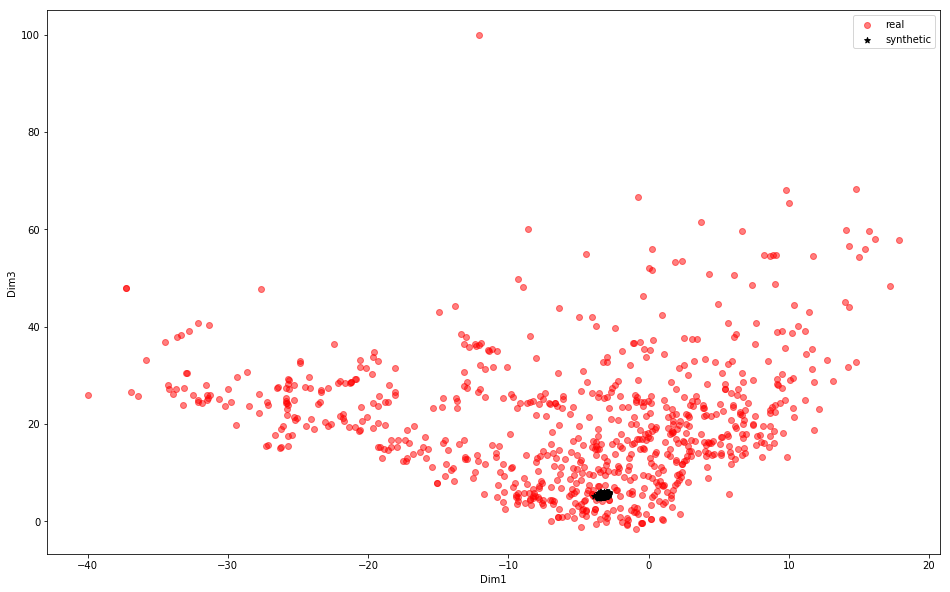

In [52]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

plt.scatter(ltnt[:,0], ltnt[:,2], c="r", marker="o", alpha = 0.5, label="real")
plt.scatter(synth[:,0], synth[:,2], c="k", marker="*", label="synthetic")

plt.legend()
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim3')
